<a href="https://colab.research.google.com/github/S3688570/Cars_Deep_Learning/blob/master/cars_transfer_learning_fine_tuning.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#CNN model of vehicle recognition - Fine tuning

In [1]:
from google.colab import drive, files
drive.mount('/content/gdrive')
gdrive_path = 'gdrive/My\ Drive/Colab\ Notebooks/'
!rsync -ah --progress\
    {gdrive_path}cars_dl/*.zip\
    '/content'
!unzip -qo '*.zip'
!rm *.zip

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=email%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdocs.test%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive.photos.readonly%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /content/gdrive
sending incremental file list
cars-20191002T050118Z-001.zip
        490.68M 100%   82.80MB/s    0:00:05 (xfr#1, to-chk=0/1)


In [0]:
epochs = 50 #@param {type:"number"}
validation_steps = 32 #@param {type:"number"}
img_height = 128 #@param {type:"integer"}
img_width = 128 #@param {type:"integer"}
batch_size = 32 #@param {type:"number"}


##Example of using a pre-trained model (VGG16) as a classifier

In [3]:
# Load Keras' VGG16 model that was pre-trained against the ImageNet database
from keras.applications import VGG16
conv_base = VGG16(weights='imagenet',
include_top=False,
input_shape=(128, 128, 3))

Using TensorFlow backend.






58892288/58889256 [==============================] - 1s 0us/step








In [4]:
# Summary of Keras' VGG16 model that was pre-trained against the ImageNet database
conv_base.summary()

Model: "vgg16"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 128, 128, 3)       0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 128, 128, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 128, 128, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 64, 64, 64)        0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 64, 64, 128)       73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 64, 64, 128)       147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 32, 32, 128)       0     

##Freeze all layers up to a specific one

In [0]:
conv_base.trainable = True

set_trainable = False
for layer in conv_base.layers:
  if layer.name == 'block4_conv2':
    set_trainable = True
  if set_trainable:
    layer.trainable = True
  else:
    layer.trainable = False

In [0]:
from keras import models
from keras import layers
model = models.Sequential()
model.add(conv_base)
model.add(layers.Flatten())
model.add(layers.Dense(256, activation='relu'))
model.add(layers.Dense(1, activation='sigmoid'))

In [7]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
vgg16 (Model)                (None, 4, 4, 512)         14714688  
_________________________________________________________________
flatten_1 (Flatten)          (None, 8192)              0         
_________________________________________________________________
dense_1 (Dense)              (None, 256)               2097408   
_________________________________________________________________
dense_2 (Dense)              (None, 1)                 257       
Total params: 16,812,353
Trainable params: 13,896,705
Non-trainable params: 2,915,648
_________________________________________________________________


In [0]:
import numpy as np
import matplotlib.pyplot as plt

#Method to print several images in a single row 
def plots(img, figsize=(12,6), rows = 1, titles = 1):
    if type(img[0]) is np.ndarray:
        img = np.array(img).astype(np.float_)
        if (img.shape[-1] != 3):
            img = img.transpose((0, 2, 3, 1))
    f =plt.figure(figsize = figsize)
    cols = 7//rows if (len(img) % 2 == 0) else len(img)//rows + 1
    for i in range(cols):
        sp = f.add_subplot(rows, cols, i+1)
        sp.axis('Off')
        if titles is not None:
            sp.set_title(titles[i], fontsize = 10)
        plt.imshow(img[i], interpolation = None if np.interp else 'none')

In [9]:
import os

trainingCarImages = os.listdir('cars/training_set/car/')
print ("Number of Training car images - ",str(len(trainingCarImages)))

trainingCrashImages = os.listdir('cars/training_set/crash/')
print ("Number of Training crash images - ",str(len(trainingCrashImages)))

validCarImages = os.listdir('cars/val_set/car/')
print ("Number of Validation car images - ",str(len(validCarImages)))

validCrashImages = os.listdir('cars/val_set/crash/')
print ("Number of Validation crash images - ",str(len(validCrashImages)))

testCarImages = os.listdir('cars/test_set/car/')
print ("Number of Test car images - ",str(len(testCarImages)))

testCrashImages = os.listdir('cars/test_set/crash/')
print ("Number of Test crash images - ",str(len(testCrashImages)))

train_data_dir = 'cars/training_set/'
validation_data_dir = 'cars/val_set/'
test_data_dir = 'cars/test_set/'
nb_train_samples = trainingCarImages + trainingCrashImages
nb_validation_samples = validCarImages + validCrashImages
nb_test_samples = testCarImages + testCrashImages

Number of Training car images -  1445
Number of Training crash images -  1445
Number of Validation car images -  375
Number of Validation crash images -  372
Number of Test car images -  129
Number of Test crash images -  131


## Training the model end-to-end with a frozen convolutional base

In [0]:
from keras.preprocessing.image import ImageDataGenerator
train_datagen = ImageDataGenerator(rescale=1./255,
                                   rotation_range=40,
                                   width_shift_range=0.2,
                                   height_shift_range=0.2,
                                   shear_range=0.2,
                                   zoom_range=0.2,
                                   horizontal_flip=True)

In [11]:
training_set = train_datagen.flow_from_directory(train_data_dir,
                                                 target_size = (128, 128),
                                                 batch_size = 32,
                                                 class_mode = 'binary',
                                                 shuffle=True,
                                                 seed=42)

test_datagen = ImageDataGenerator(rescale = 1./255)

val_set = test_datagen.flow_from_directory(validation_data_dir,
                                            target_size = (128, 128),
                                            batch_size = 32,
                                            class_mode = 'binary',
                                            shuffle=True,
                                            seed=42)

test_set = test_datagen.flow_from_directory(test_data_dir,
                                            target_size = (128, 128),
                                            batch_size = 32,
                                            class_mode = 'binary',
                                            shuffle=True,
                                            seed=42)


Found 2890 images belonging to 2 classes.
Found 747 images belonging to 2 classes.
Found 260 images belonging to 2 classes.


## Print normalized and re-sized images from training set

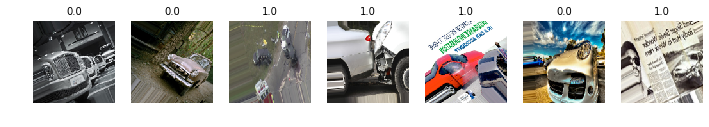

In [12]:
imgs, labels = next(training_set)
plots(imgs, titles = labels)

## Print normalized and re-sized images from validation set

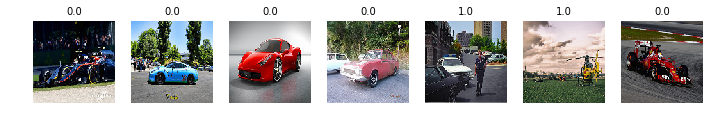

In [13]:
imgs, labels = next(val_set)
plots(imgs, titles = labels)

## Compile model

In [14]:
from keras import optimizers
model.compile(optimizer = 'adam', loss = 'binary_crossentropy', metrics = ['accuracy'])



Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


In [0]:
#Method to identify and remove corrupted images
def my_gen(gen):
    while True:
        try:
            imgs, labels = next(gen)
            yield imgs, labels
        except:
            pass

##Fine-tuning the model

In [16]:
model.compile(loss='binary_crossentropy',
              optimizer=optimizers.RMSprop(lr=1e-5),
              metrics=['acc'])

history = model.fit_generator(
    my_gen(training_set),
    steps_per_epoch=100,
    epochs=50,
    validation_data=val_set,
    validation_steps=50)



Epoch 1/50
 36/100 [=========>....................] - ETA: 32s - loss: 0.6012 - acc: 0.6753

/usr/local/lib/python3.6/dist-packages/PIL/Image.py:914: UserWarning: Palette images with Transparency   expressed in bytes should be converted to RGBA images
  'to RGBA images')


100/100 [==============================] - 59s 592ms/step - loss: 0.5148 - acc: 0.7426 - val_loss: 0.5168 - val_acc: 0.7805
Epoch 2/50
100/100 [==============================] - 52s 524ms/step - loss: 0.3964 - acc: 0.8271 - val_loss: 0.4756 - val_acc: 0.8081
Epoch 3/50
100/100 [==============================] - 53s 527ms/step - loss: 0.3535 - acc: 0.8487 - val_loss: 0.4947 - val_acc: 0.8055
Epoch 4/50
100/100 [==============================] - 52s 516ms/step - loss: 0.3343 - acc: 0.8534 - val_loss: 0.5627 - val_acc: 0.7792
Epoch 5/50
100/100 [==============================] - 51s 514ms/step - loss: 0.3015 - acc: 0.8779 - val_loss: 0.3834 - val_acc: 0.8614
Epoch 6/50
100/100 [==============================] - 51s 509ms/step - loss: 0.2864 - acc: 0.8809 - val_loss: 0.4051 - val_acc: 0.8517
Epoch 7/50
100/100 [==============================] - 52s 516ms/step - loss: 0.2652 - acc: 0.8962 - val_loss: 0.4359 - val_acc: 0.8421
Epoch 8/50
100/100 [==============================] - 52s 517ms/st

In [17]:
# list all data in history
print(history.history.keys())

dict_keys(['val_loss', 'val_acc', 'loss', 'acc'])


## Save neural network structure

In [18]:
from pathlib import Path
import os
transferModelFineTune_structure = model.to_json()
f = Path("gdrive/My Drive/Colab Notebooks/transferModelFineTune_structure.json")
f.write_text(transferModelFineTune_structure)

11826

## Save neural network's trained weights

In [0]:
# Save neural network's trained weights
model.save_weights("gdrive/My Drive/Colab Notebooks/transferModelFineTune_weights.h5")
model.save('gdrive/My Drive/Colab Notebooks/transferModelFineTune_weights.h5')

## Plot training and validation accuracy per epoch

Exception ignored in: <generator object my_gen at 0x7f1570237678>
RuntimeError: generator ignored GeneratorExit


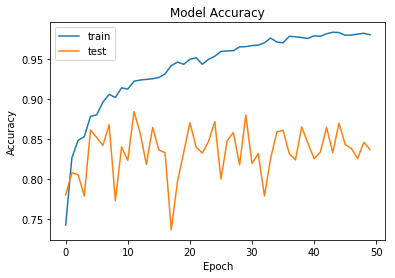

In [20]:
import matplotlib.pyplot as plt
plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

## Plot training and validation loss per epoch

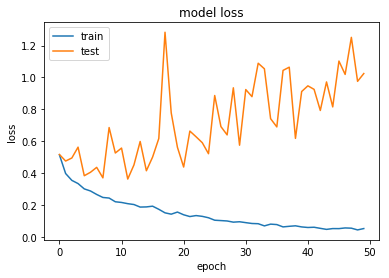

In [21]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

###Smoothed plots

<Figure size 432x288 with 0 Axes>

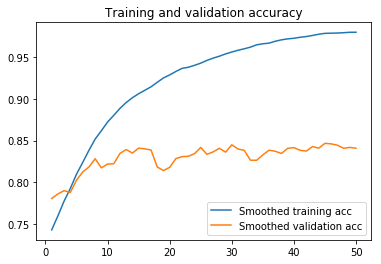

<Figure size 432x288 with 0 Axes>

In [22]:
import matplotlib.pyplot as plt
import numpy as np

def smooth_curve(points, factor=0.8):
  smoothed_points = []
  for point in points:
    if smoothed_points:
      previous = smoothed_points[-1]
      smoothed_points.append(previous * factor + point * (1 - factor))
    else:
      smoothed_points.append(point)
  return smoothed_points

acc = history.history['acc']
val_acc = history.history['val_acc']
epoch = range(1, len(acc) + 1)
  
plt.plot(epoch, smooth_curve(acc), 'tab:blue', label='Smoothed training acc')
plt.plot(epoch, smooth_curve(val_acc), 'tab:orange', label='Smoothed validation acc') 
plt.title('Training and validation accuracy')
plt.legend(loc='lower right')
plt.figure()

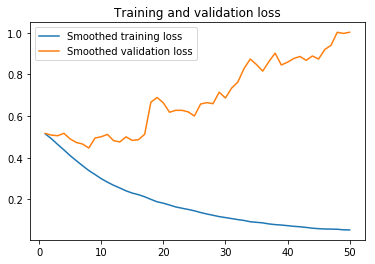

In [23]:
loss = history.history['loss']
val_loss = history.history['val_loss']
epoch = range(1, len(loss) + 1)

plt.plot(epoch, smooth_curve(loss), 'tab:blue', label='Smoothed training loss')
plt.plot(epoch, smooth_curve(val_loss), 'tab:orange', label='Smoothed validation loss')
plt.title('Training and validation loss')
plt.legend()
plt.show()